# Train YOLO Models in Google Colab

# Introduction

This notebook uses [Ultralytics](https://docs.ultralytics.com/) to train YOLO11, YOLOv8, or YOLOv5 object detection models with a custom dataset.

At the end of this Colab, you'll have a custom YOLO model that you can run on your PC, phone, or edge device like the Raspberry Pi.



**Verify NVIDIA GPU Availability**

Make sure you're using a GPU-equipped machine by going to "Runtime" -> "Change runtime type" in the top menu bar, and then selecting one of the GPU options in the Hardware accelerator section. Click Play on the following code block to verify that the NVIDIA GPU is present and ready for training.

In [ ]:
!nvidia-smi

Thu Jun 19 14:32:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#1.&nbsp;Gather and Label Training Images

Before we start training, we need to gather and label images that will be used for training the object detection model. A good starting point for a proof-of-concept model is 200 images. The training images should have random objects in the image along with the desired objects, and should have a variety of backgrounds and lighting conditions.

There are a couple options for gathering images:


*   Build a custom dataset by taking your own pictures of the objects and labeling them (this typically results in the best performance)

One good option is [Label Studio](https://labelstud.io/integrations/machine-learning/yolo/), a free and open-source labeling tool that has a simple workflow while providing capabilities for more advanced features.

<p align="center">
  <img src="https://raw.githubusercontent.com/samriddhashaikh/YOLO/main/assets/Data_Folder_Structure.png" height="380">
</p>

<br>

<i>Example images labeled with Label Studio.</i>
</p>

If you used Label Studio to label and export the images, they'll be exported in a `project.zip` file that contains the following:

- An `images` folder containing the images
- A `labels` folder containing the labels in YOLO annotation format
- A `classes.txt` labelmap file that contains all the classes
- A `notes.json` file that contains info specific to Label Studio (this file can be ignored)


Once you've got your dataset built, put into the file structure shown above, and zipped into `YOLO_Data.zip`, you're ready to move on to the next step.

# 2.&nbsp;Upload Image Dataset and Prepare Training Data

Next, we'll upload our dataset and prepare it for training with YOLO. We'll split the dataset into train and validation folders, and we'll automatically generate the configuration file for training the model.

## 2.1 Upload images

First, we need to upload the dataset to Colab. Here are a few options for moving the `data.zip` folder into this Colab instance.

**Upload through Google Colab**

Upload the `YOLO_Data.zip` file to the Google Colab instance by clicking the "Files" icon on the left hand side of the browser, and then the "Upload to session storage" icon. Select the zip folder to upload it.

<p>
<br>
<img src="https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/doc/upload-colab-files.png" height="240">
</p>


#2.2 Unzip Training Data in a local folder

Click the icon to upload the `YOLO_Data.zip` file in the list of files.

## Unzip the file into **custom_data** subdirectory.

Next, we'll unzip `YOLO_Data.zip` and create some folders to hold the images.

Run the following code block to unzip the data in a local directory named **custom_data**.

# 2.3 Split images into train and validation folders

In [18]:
# Unzip images to a custom data folder
!unzip -q /content/YOLO_Data.zip -d /content/custom_data

## Arrange Data in a folder structure suitable for Training Ultralytics models.

**Ultralytics requires a particular folder structure to store training data for models.**

The root folder is named “**data**”. Inside, there are two main folders:

*   **train**: These are the actual images used to train the model. In one epoch of training, every image in the train set is passed into the neural network. The training algorithm adjusts the network weights to fit the data in the images.


*   **validation**: These images are used to check the model's performance at the end of each training epoch.

In each of these folders is a “**images**” folder and a “**labels**” folder, which hold the image files and annotation files respectively.


A Python script is provided on the Github page that will automatically create the required folder structure and randomly move 90% of dataset to the "train" folder and 10% to the "validation" folder. Run the following code block to download and execute the scrpt.

In [19]:
import os
import shutil
import random
from pathlib import Path

# Set manually in Colab
data_path = '/content/custom_data'  # Should contain 'images' and 'labels' subfolders
train_percent = 0.9

# Input paths
input_image_path = os.path.join(data_path, 'images')
input_label_path = os.path.join(data_path, 'labels')

# Output paths
train_img_path = '/content/data/train/images'
train_lbl_path = '/content/data/train/labels'
val_img_path = '/content/data/validation/images'
val_lbl_path = '/content/data/validation/labels'

# Create output folders
for dir_path in [train_img_path, train_lbl_path, val_img_path, val_lbl_path]:
    os.makedirs(dir_path, exist_ok=True)

# Get list of images
img_file_list = list(Path(input_image_path).rglob('*.*'))
random.shuffle(img_file_list)

train_num = int(len(img_file_list) * train_percent)
train_files = img_file_list[:train_num]
val_files = img_file_list[train_num:]

print(f'Train images: {len(train_files)}')
print(f'Val images: {len(val_files)}')

def copy_files(file_list, img_dest, lbl_dest):
    for img_path in file_list:
        img_fn = img_path.name
        base_fn = img_path.stem
        txt_fn = base_fn + '.txt'
        txt_path = os.path.join(input_label_path, txt_fn)

        shutil.copy(img_path, os.path.join(img_dest, img_fn))
        if os.path.exists(txt_path):
            shutil.copy(txt_path, os.path.join(lbl_dest, txt_fn))

copy_files(train_files, train_img_path, train_lbl_path)
copy_files(val_files, val_img_path, val_lbl_path)

Train images: 216
Val images: 25


# 3.&nbsp;Install Requirements (Ultralytics)

Next, we'll install the Ultralytics library in this Google Colab instance. This Python library will be used to train the YOLO model.

In [22]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

# 4. Configure Training - Create "data.yaml" file




There's one last step before we can run training: we need to create the Ultralytics training configuration YAML file. This file specifies the location of your train and validation data, and it also defines the model's classes. An example configuration file model is available [here](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/coco128.yaml).

Run the code block below to automatically generate a `data.yaml` configuration file. Make sure you have a labelmap file located at `custom_data/classes.txt`. If you used Label Studio or one of my pre-made datasets, it should already be present. If you assembled the dataset another way, you may have to manually create the `classes.txt` file.

In [20]:

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):
    # Read classes.txt to get class names
    if not os.path.exists(path_to_classes_txt):
        print(f'❌ classes.txt file not found! Please place it at: {path_to_classes_txt}')
        return

    with open(path_to_classes_txt, 'r') as f:
        classes = [line.strip() for line in f if line.strip()]
    number_of_classes = len(classes)

    # Create data.yaml dictionary
    data = {
        'path': '/content/data',
        'train': 'train/images',
        'val': 'validation/images',
        'nc': number_of_classes,
        'names': classes
    }

    # Write data.yaml
    with open(path_to_data_yaml, 'w') as f:
        yaml.dump(data, f, sort_keys=False)
    print(f'✅ Created config file at {path_to_data_yaml}')

# Set paths and run
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

# Show file contents
print('\nFile contents:\n')
!cat /content/data.yaml


✅ Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 9
names:
- auto
- bike
- bus
- car
- person
- phone
- remote
- traffic_cone
- traffic_light


# 5.&nbsp;Train Model

## 5.1 Training Parameters
Now that the data is organized and the config file is created, we're ready to start training! First, there are a few important parameters to decide on.

## Choose important parameters for Training

**Model architecture & size (`model`):**

There are several YOLO11 models sizes available to train, including `yolo11n.pt`, `yolo11s.pt`, `yolo11m.pt`, `yolo11l.pt`, and `yolo11xl.pt`. Larger models run slower but have higher accuracy, while smaller models run faster but have lower accuracy.

You can also train YOLOv8 or YOLOv5 models by substituting `yolo11` for `yolov8` or `yolov5`.


**Number of epochs (`epochs`)**

In machine learning, one “epoch” is one single pass through the full training dataset. Setting the number of epochs dictates how long the model will train for. The best amount of epochs to use depends on the size of the dataset and the model architecture. If your dataset has less than 200 images, a good starting point is 60 epochs. If your dataset has more than 200 images, a good starting point is 40 epochs.


**Resolution (`imgsz`)**

Resolution has a large impact on the speed and accuracy of the model: a lower resolution model will have higher speed but less accuracy. YOLO models are typically trained and inferenced at a 640x640 resolution. However, if you want your model to run faster or know you will be working with low-resolution images, try using a lower resolution like 480x480.


## 5.2 Run Training!

Run the following code block to begin training. If you want to use a different model, number of epochs, or resolution, change `model`, `epochs`, or `imgsz`.

In [23]:
!yolo detect train data=/content/data.yaml model=yolo11n.pt epochs=60 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 5.35M/5.35M [00:00<00:00, 124MB/s]
Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, i

The training algorithm will parse the images in the training and validation directories and then start training the model. At the end of each training epoch, the program runs the model on the validation dataset and reports the resulting mAP, precision, and recall. As training continues, the mAP should generally increase with each epoch. Training will end once it goes through the number of epochs specified by `epochs`.

> **NOTE:** Make sure to allow training to run to completion, because an optimizer runs at the end of training that strips out unneeded layers from the model.

The best trained model weights will be saved in `content/runs/detect/train/weights/best.pt`. Additional information about training is saved in the `content/runs/detect/train` folder, including a `results.png` file that shows how loss, precision, recall, and mAP progressed over each epoch.

#6.&nbsp;Test Model

The model has been trained; now it's time to test it! The commands below run the model on the images in the validation folder and then display the results for the first 10 images. This is a good way to confirm your model is working as expected. Click Play on the blocks below to see how your model performs.

In [24]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,907 parameters, 0 gradients, 6.3 GFLOPs

image 1/25 /content/data/validation/images/0be7d497-image_20250618-202634.jpg: 480x640 12 cars, 45.3ms
image 2/25 /content/data/validation/images/202db693-image_20250618-203109.jpg: 480x640 12 cars, 8.7ms
image 3/25 /content/data/validation/images/34a3aff1-image_20250618-203303.jpg: 480x640 13 cars, 4 phones, 8.1ms
image 4/25 /content/data/validation/images/3bce172b-image_20250618-201432.jpg: 480x640 2 cars, 14.0ms
image 5/25 /content/data/validation/images/3fbc232e-image_20250618-203057.jpg: 480x640 13 cars, 11.3ms
image 6/25 /content/data/validation/images/466b3622-image_20250618-202224.jpg: 480x640 12 cars, 7.8ms
image 7/25 /content/data/validation/images/49f8f902-image_20250618-202211.jpg: 480x640 12 cars, 7.7ms
image 8/25 /content/data/validation/images/514db436-image_20250618-203043.jpg: 480x640 12 cars, 7.8ms
image

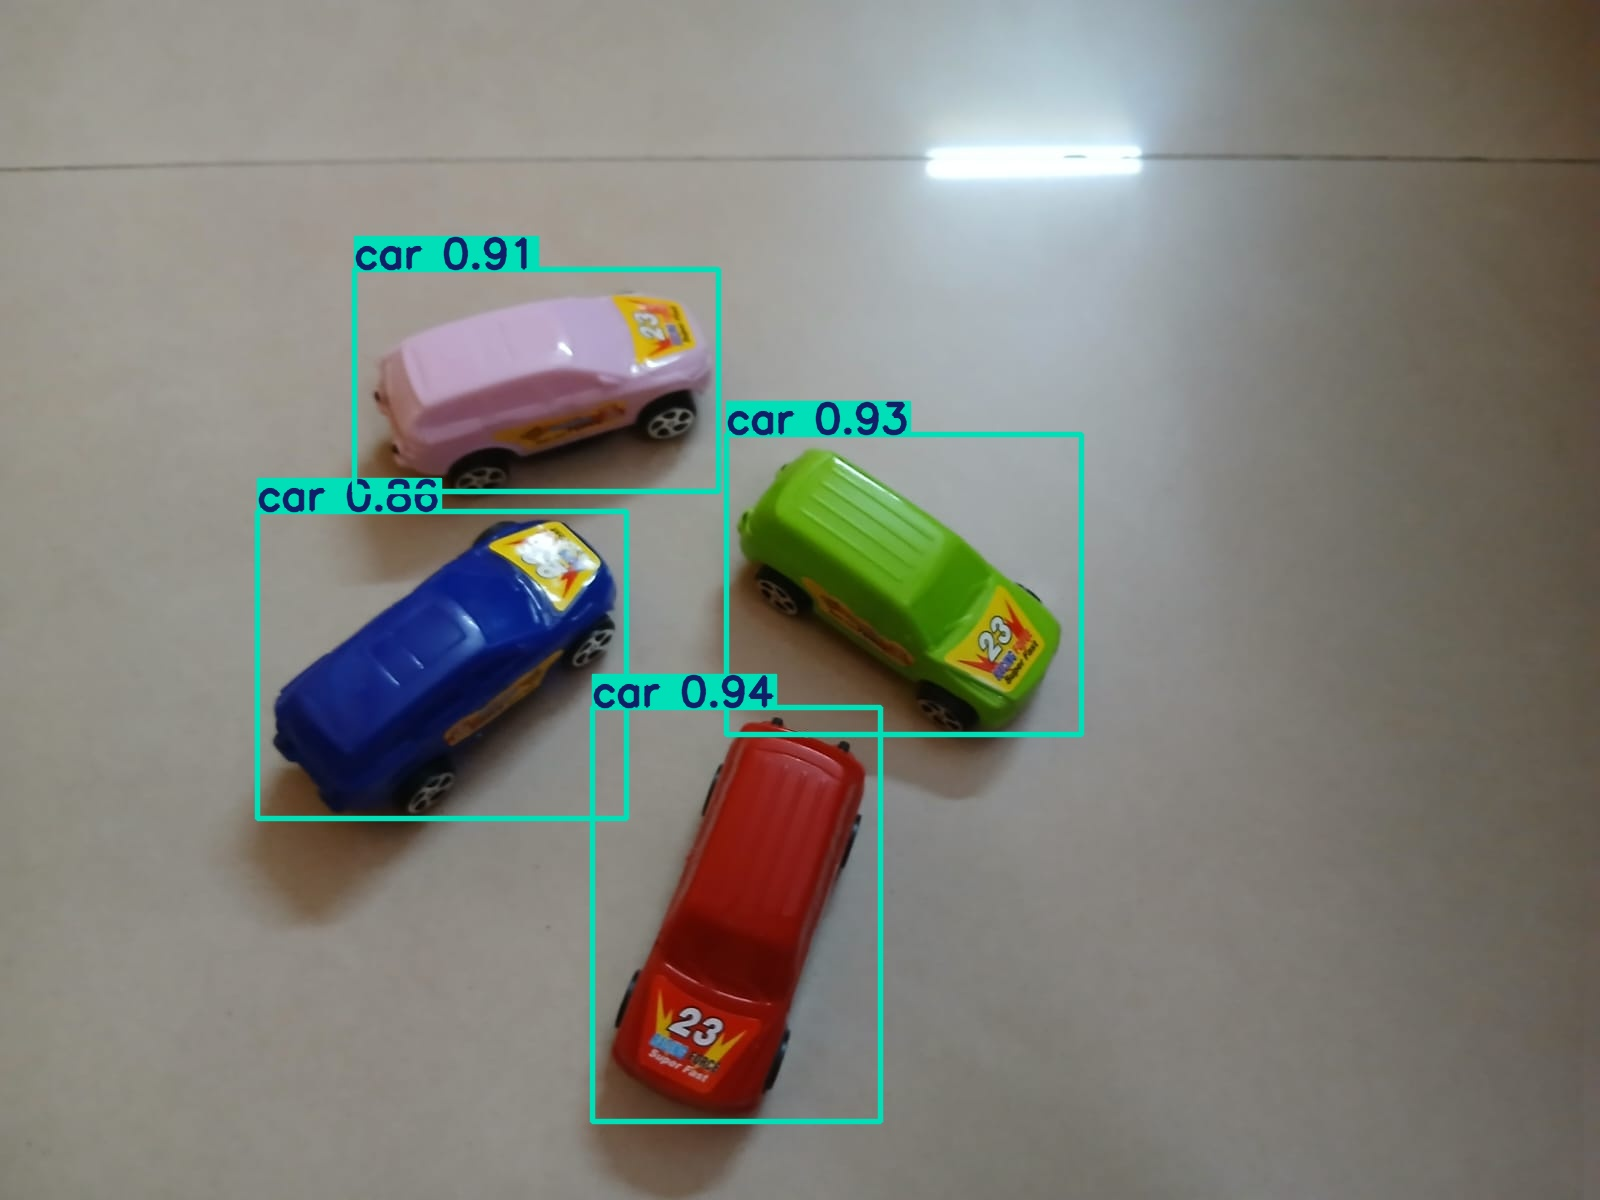

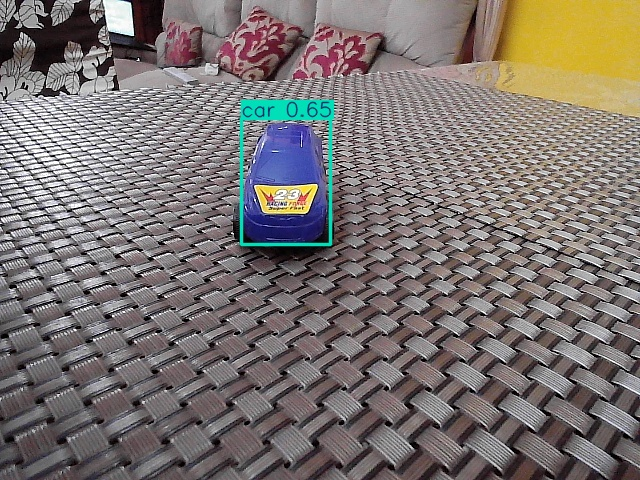

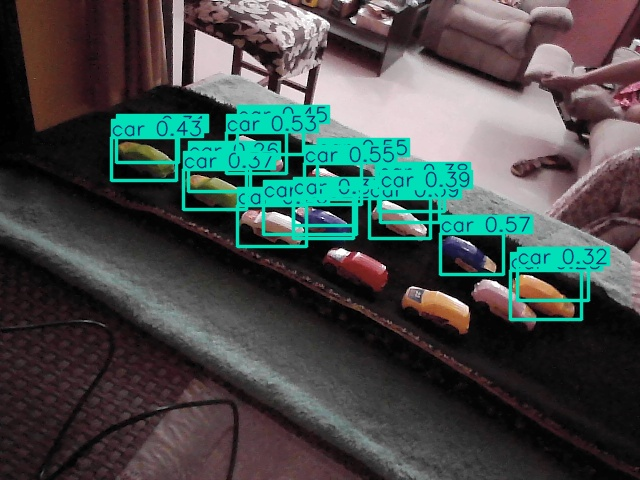

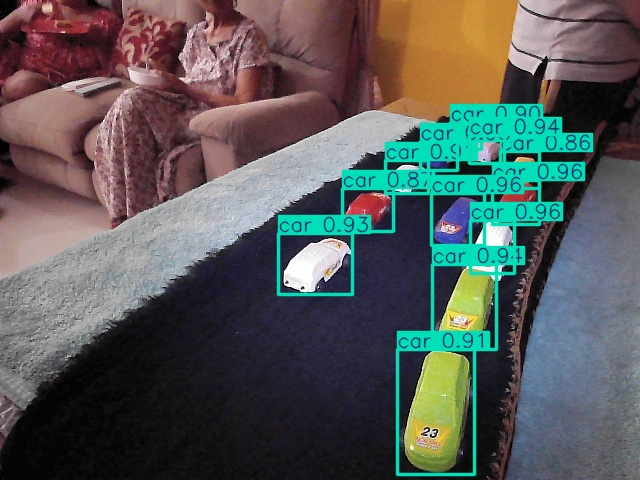

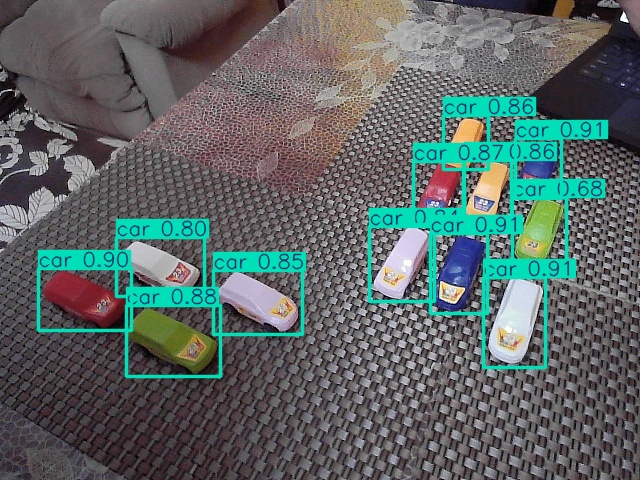

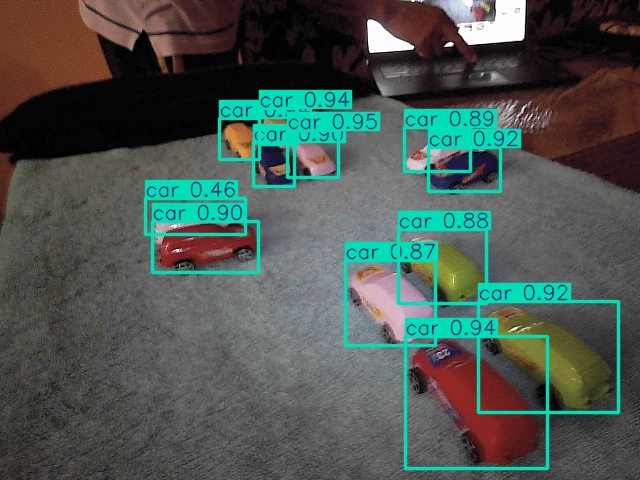

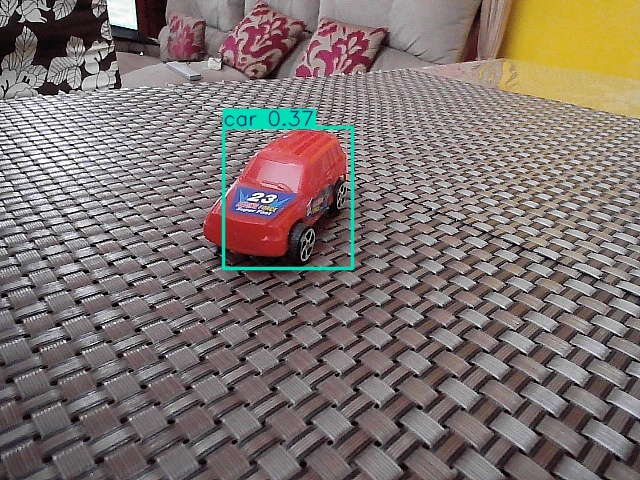

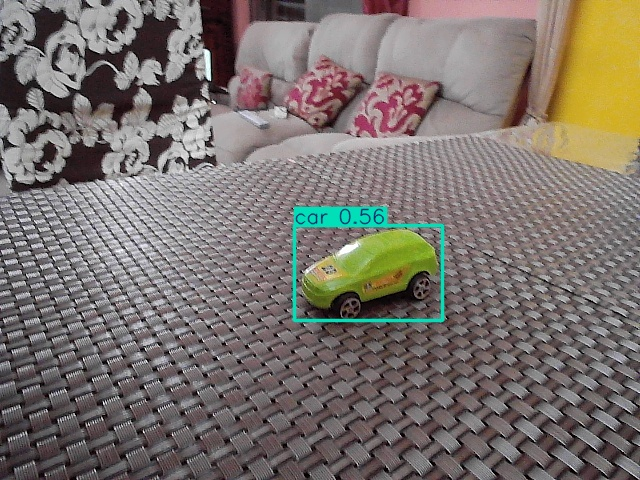

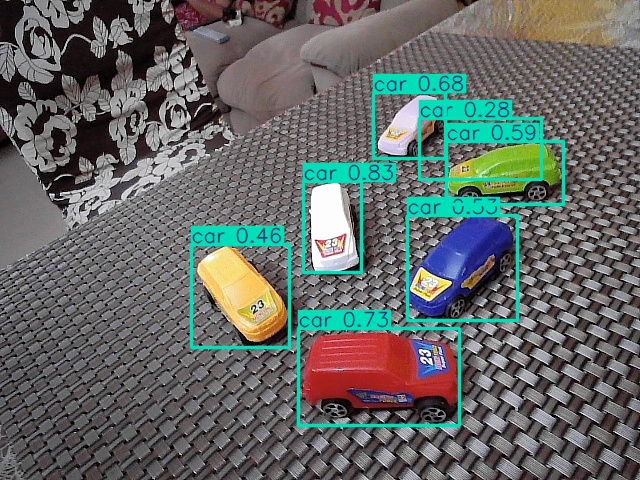

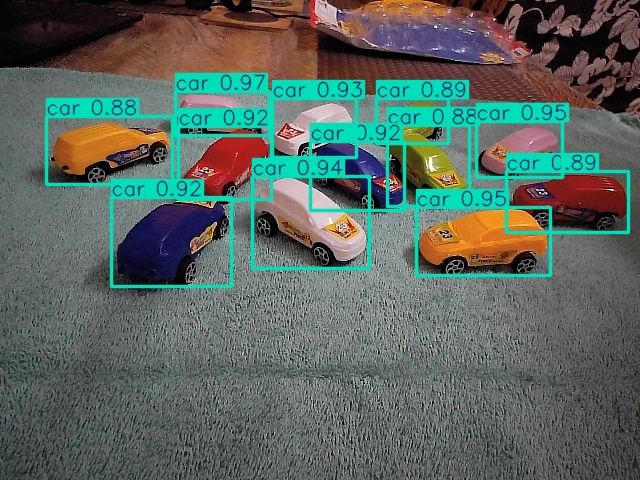

In [25]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


The model should draw a box around each object of interest in each image. If it isn't doing a good job of detecting objects, here are a few tips:

1. Double-check your dataset to make sure there are no labeling errors or conflicting examples.
2. Increase the number of epochs used for training.
3. Use a larger model size (e.g. `yolo11l.pt`).
4. Add more images to the training dataset.

You can also run the model on video files or other images images by uploading them to this notebook and using the above `!yolo detect predict` command, where `source` points to the location of the video file, image, or folder of images. The results will be saved in `runs/detect/predict`.

Drawing boxes on images is great, but it isn't very useful in itself. It's also not very helpful to just run this models inside a Colab notebook: it's easier if we can just run it on a local computer. Continue to the next section to see how to download your newly trained model and run it on a local device.

#7.&nbsp;Deploy Model

Now that your custom model has been trained, it's ready to be downloaded and deployed in an application! YOLO models can run on a wide variety of hardware, including PCs, embedded systems, and phones. Ultralytics makes it easy to convert the YOLO models to various formats (`tflite`, `onnx`, etc.) and deploy them in a variety of environments.

This section shows how to download the model and provides links to instructions for deploying it on your PC and edge devices like the Raspberry Pi.

## 7.1 Download YOLO Model

First, zip and download the trained model by running the code blocks below.

The code creates a folder named `my_model`, moves the model weights into it, and renames them from `best.pt` to `my_model.pt`. It also adds the training results in case you want to reference them later. It then zips the folder as `my_model.zip`.

In [26]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 10%)
  adding: train/ (stored 0%)
  adding: train/train_batch701.jpg (deflated 9%)
  adding: train/results.png (deflated 6%)
  adding: train/confusion_matrix.png (deflated 26%)
  adding: train/train_batch2.jpg (deflated 2%)
  adding: train/P_curve.png (deflated 10%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/best.pt (deflated 10%)
  adding: train/weights/last.pt (deflated 10%)
  adding: train/labels.jpg (deflated 29%)
  adding: train/labels_correlogram.jpg (deflated 37%)
  adding: train/train_batch700.jpg (deflated 7%)
  adding: train/results.csv (deflated 61%)
  adding: train/train_batch1.jpg (deflated 2%)
  adding: train/val_batch0_labels.jpg (deflated 5%)
  adding: train/confusion_matrix_normalized.png (deflated 25%)
  adding: train/train_batch702.jpg (deflated 7%)
  adding: train/F1_curve.png (deflated 8%)
  adding: train/args.yaml (deflated 53%)
  adding: train/train_batch0.jpg (deflated 2%)
  adding: train/val_ba

In [27]:
# This takes forever for some reason, you can also just download the model from the sidebar
from google.colab import files

files.download('/content/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 7.2 Deploy YOLO Model on Local Devices

Next, we'll take our downloaded model and run it on a local device. This section provides instructions showing how to deploy YOLO models on various devices.

I wrote a basic Python script, `yolo_detect.py`, that shows how to load a model, run inference on an image source, parse the inference results, and display boxes around each detected class in the image.
The [script](https://github.com/samriddhashaikh/YOLO/blob/main/yolo_detect.py) gives an example of how to work with Ultralytics YOLO models in Python, and it can be used as a starting point for more advanced applications.

### 7.2.1 Deploy on PC (Windows, Linux, or macOS)

The easiest way to run Ultralytics models on a PC is using a virtual environment.
Virtual Python environment and allows you to easily install Ultralytics and PyTorch. It automatically installs CUDA and cuDNN, which allows you to speed up model inference with your NVIDIA GPU.


**2. Set up virtual environment**


Issue the following commands to create a new Python environment and activate it:

```
python -m venv yolo
yolo/Scripts/activate
```
On your Windows Laptop, activate the virtual environment by running the following command:
```
yolo/Scripts/activate
```
On your Raspberry-Pi, activate the virtual environment by running the following command:

```
source yolo/bin/activate
```

Install Ultralytics (which also installs import libraries like OpenCV-Python, Numpy, and PyTorch) by issuing the following command:

```
pip install ultralytics
```


**3. Extract downloaded model**
Take the `my_model.zip` file you downloaded earlier and unzip it to a folder on your PC. Move into the unzipped folder using:

```
cd path/to/folder
```

**4. Download and run yolo_detect.py**

Download the `yolo_detect.py` script into the `my_model` folder using:

```
curl -o yolo_detect.py https://github.com/samriddhashaikh/YOLO/blob/main/yolo_detect.py
```

To run inference with a yolov8s model on a USB camera, issue:

```
python yolo_detect.py
```

A window will appear showing a live feed from your webcam with boxes drawn around detected objects in each frame.




### 7.2.2 Deploy on Raspberry Pi

Keep an eye out for an article showing how to convert YOLO models to NCNN format and run them on the Raspberry Pi!